# Modelo predador-presa utilizando as equações de Lotka-Volterra

## Introdução

A natureza é um sistema dinâmico de interações complexas. Entre os exemplos mais elegantes dessa complexidade está a relação **predador-presa** — um equilíbrio delicado entre crescimento e extinção, abundância e escassez. Compreender essas interações é fundamental não apenas para a biologia, mas também para áreas como **Engenharia de controle**, **Economia**, **Ecologia de sistemas**, e **Ciência de dados aplicada à modelagem dinâmica**.

Em 1925, **Alfred J. Lotka** e, de forma independente, **Vito Volterra** propuseram um conjunto de **equações diferenciais não lineares** capazes de descrever matematicamente essa interação entre duas populações: uma de presas (geralmente herbívoros) e outra de predadores (carnívoros que dependem delas para sobreviver).
Essas equações se tornaram um dos modelos mais influentes da **teoria dos sistemas dinâmicos**, demonstrando como comportamentos oscilatórios e cíclicos emergem naturalmente em sistemas simples.

Neste estudo, exploraremos o modelo de Lotka-Volterra, implementado em Python com o auxílio de ferramentas científicas como NumPy, SciPy e Matplotlib.
O objetivo é mostrar, de forma prática e visual, como uma formulação matemática pode se transformar em um simulador computacional capaz de revelar padrões complexos de interação — e, ao mesmo tempo, servir de ponto de partida para extensões mais sofisticadas, como controle, otimização e identificação de parâmetros.

Ao final, você compreenderá:

- Como o modelo é formulado e resolvido numericamente;
- Como interpretar os resultados no domínio do tempo e no plano de fase;
- De que maneira pequenas alterações nos parâmetros podem alterar radicalmente o comportamento do sistema.

## Formulação Matemática

O modelo de **Lotka-Volterra** descreve a dinâmica entre duas populações que interagem em um mesmo ecossistema: uma de **presas** (geralmente herbívoros ou espécies produtoras) e uma de **predadores** (espécies consumidoras que dependem das presas para sobreviver).

A ideia central é capturar o comportamento **auto-limitante e interdependente** dessas populações, representando-as por meio de um **sistema de equações diferenciais não lineares de primeira ordem**:

$$
\begin{cases}
\dfrac{dX}{dt} = \alpha X - \beta XY \\ \\
\dfrac{dY}{dt} = \delta XY - \gamma Y
\end{cases}
$$

Onde:

- $ X(t) $: tamanho da população de **presas** no tempo $ t $
- $ Y(t) $: tamanho da população de **predadores** no tempo $ t $
- $ \alpha $: taxa de crescimento natural das presas (sem predadores) ou **taxa de natalidade**
- $ \beta $: taxa de **predação**, ou probabilidade de encontro presa–predador
- $ \gamma $: taxa de **mortalidade natural** dos predadores (sem presas)
- $ \delta $: eficiência de conversão de presas em novos predadores

### Interpretação física e biológica

A primeira equação expressa que a população de presas tende a crescer proporcionalmente ao número de presas $(\alpha X)$ quando não há predadores, mas diminui proporcionalmente ao número de interações predador-presa $(-\beta XY)$.

A segunda equação indica que os predadores dependem da disponibilidade de presas para se reproduzir $(\delta XY)$, porém sofrem declínio natural quando as presas escasseiam $(-\gamma Y)$.

Essas interações recíprocas geram **ciclos oscilatórios** de abundância e escassez: quando há muitas presas, os predadores prosperam; à medida que os predadores se multiplicam, as presas diminuem, provocando posteriormente o declínio dos próprios predadores — e o ciclo recomeça.

### Pontos de equilíbrio

O sistema admite dois pontos de equilíbrio notáveis:

1. $(X^*, Y^*) = (0, 0)$  — extinção mútua.
2. $(X^*, Y^*) = \left(\dfrac{\gamma}{\delta}, \dfrac{\alpha}{\beta}\right)$ — coexistência estável entre predador e presa.

Em torno do segundo ponto, as soluções apresentam **trajetórias periódicas fechadas** no plano de fase $(X,Y)$, revelando o comportamento cíclico característico do modelo.

### Limitações e extensões

Embora elegante, o modelo de Lotka-Volterra é **puramente determinístico e idealizado**. Ele não considera efeitos como capacidade de suporte do ambiente, saturação de predação, mutações, doenças ou estocasticidade ambiental. Por isso, é frequentemente usado como **modelo de referência** — um ponto de partida para variantes mais realistas, como:

- **Modelo de Rosenzweig-MacArthur**, que inclui crescimento logístico das presas;
- **Modelo com atraso temporal** (time delay), usado para analisar estabilidade e bifurcações;
- **Abordagens estocásticas e discretas**, aplicadas em simulações de ecossistemas complexos.

## Implementação em Python

Nesta seção, implementamos o modelo clássico de **Lotka–Volterra** em Python usando `NumPy`, `SciPy` e `Matplotlib`.

Você poderá: 
1. Simular a dinâmica temporal, 
2. Visualizar o **plano de fase** 
3. Testar a **sensibilidade de parâmetros**.

### Requisitos

```
pip install numpy scipy matplotlib
```
> Testado em Python ≥ 3.9, NumPy ≥ 1.24, SciPy ≥ 1.10, Matplotlib ≥ 3.7.

### Núcleo do modelo (funções utilitárias)

In [1]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


@dataclass
class LVParams:
    """Parâmetros do modelo de Lotka–Volterra."""
    alpha: float = 1.0   # taxa de crescimento das presas (sem predadores) [%]
    beta:  float = 0.1   # taxa de predação (acoplamento X–Y) [%]
    gamma: float = 1.5   # taxa de mortalidade natural dos predadores (sem presas) [%]
    delta: float = 0.075 # eficiência de conversão de presas em predadores ou taxa de reprodução dos predadores [%]

# Função diferencial
def lv_ode(t: float, z: np.ndarray, p: LVParams) -> list:
    """
    Campo vetorial do sistema de Lotka–Volterra.
    z = [X, Y], sendo X presas e Y predadores.
    """
    x, y = z
    dxdt = p.alpha * x - p.beta * x * y
    dydt = p.delta * x * y - p.gamma * y
    return [dxdt, dydt]

def simulate_lv(params: LVParams,
                z0=(10.0, 5.0),
                t_span=(0.0, 50.0),
                n_points=1000,
                rtol=1e-8, atol=1e-10):
    """
    Integra numericamente o sistema e retorna tempos e trajetórias (X(t), Y(t)).
    """
    t_eval = np.linspace(t_span[0], t_span[1], n_points)
    sol = solve_ivp(lambda t, z: lv_ode(t, z, params),
                    t_span=t_span, y0=np.array(z0, dtype=float),
                    t_eval=t_eval, rtol=rtol, atol=atol, vectorized=False)
    if not sol.success:
        raise RuntimeError(f"Falha na integração: {sol.message}")
    return sol.t, sol.y[0], sol.y[1]

def equilibrium_points(params: LVParams):
    """
    Retorna os dois pontos de equilíbrio:
    E0 = (0, 0)
    E1 = (gamma/delta, alpha/beta)
    """
    e0 = (0.0, 0.0)
    e1 = (params.gamma / params.delta, params.alpha / params.beta)
    return e0, e1

def plot_time_series(t, X, Y, params: LVParams, z0,filename='lv_time_series.png'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(t, X, label='Presas (X)')
    plt.plot(t, Y, label='Predadores (Y)')
    plt.xlabel('Tempo')
    plt.ylabel('População')
    plt.title('Dinâmica Predador–Presa (Lotka–Volterra)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=160)
    plt.show()

def plot_phase_plane(X, Y, params: LVParams, z0,filename='lv_phase_plane.png'):
    e0, e1 = equilibrium_points(params)

    plt.figure(figsize=(5.5, 5.5))
    plt.plot(X, Y, linewidth=2.0, label='Trajetória')
    plt.scatter([z0[0]], [z0[1]], marker='p', s=120,  color='red', label='Condição inicial em $t_0$')
    plt.scatter([e0[0]], [e0[1]], marker='x', s=80, label='Equilíbrio (0,0)')
    plt.scatter([e1[0]], [e1[1]], marker='o', s=60, label=r'Equilíbrio $(\gamma/\delta,\ \alpha/\beta)$')
    plt.xlabel('Presas (X)')
    plt.ylabel('Predadores (Y)')
    plt.title('Plano de Fase')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(filename, dpi=160)
    plt.show()

### Gráficos: séries temporais e plano de fase

**Saída esperada:**
> 1. **Curvas $X(t)$ e $Y(t)$ com oscilações periódicas.**
> 2. **Órbita fechada em torno do ponto $(γ/δ, α/β)$.**

#### 1ª simulação: Condições de equilíbrio dinâmico com comportamento oscilatório sustentado
**Condições iniciais**
> * $\alpha$ - Taxa de crescimento das presas sem predadores: **1.0** 
> * $\beta$ - Taxa de predação, acoplamento X–Y: **0.1**
> * $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas: **1.5**  
> * $\delta$ - Eficiência de conversão de presas em predadores ou taxa de reprodução dos predadores: **0.075** 
> * $X$ - Tamanho da população de **Presas** no tempo $ t=0 $ : **10**
> * $Y$ - Tamanho da população de **Predadores** no tempo $ t=0 $ : **5**

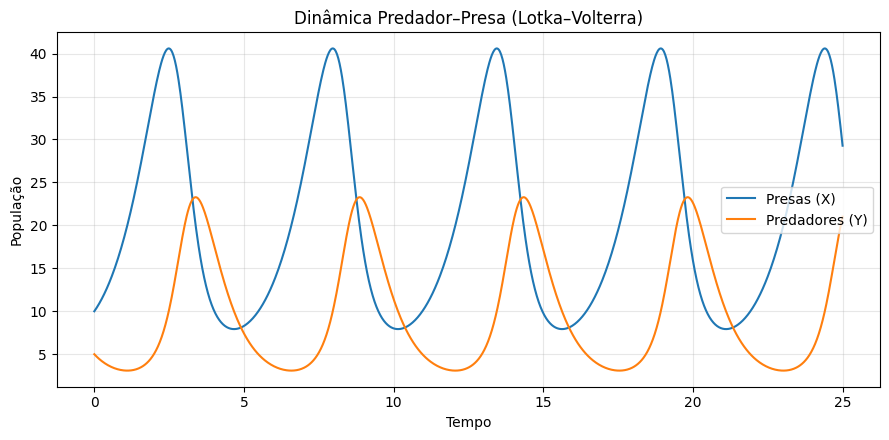

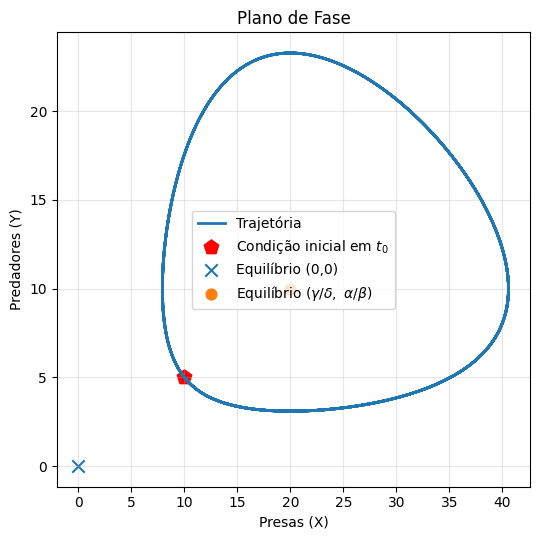

In [2]:
params = LVParams(alpha=1.0, beta=0.1, gamma=1.5, delta=0.075)
z0 = (10.0, 5.0)
t, X, Y = simulate_lv(params, z0=z0, t_span=(0, 25), n_points=1200)
plot_time_series(t, X, Y, params, z0,filename='lv_time_series_1.png')
plot_phase_plane(X, Y, params, z0,filename='lv_phase_plane_1.png')

### Análise da sensibilidade a variação de parâmetros (variação de $\alpha$ e $\gamma$)

Este experimento ilustra como pequenas alterações nos parâmetros **mudam o período e a amplitude** das oscilações.

#### 2ª simulação: Análise de sensibilidade do modelo à variação do parâmetro $\alpha$ - Taxa de crescimento das presas sem predadores
**Condições iniciais**
> * $\alpha$ - Taxa de crescimento das presas sem predadores: **[0.8, 1.0, 1.2]**
> * $\beta$ - Taxa de predação, acoplamento X–Y: **0.1**
> * $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas: **1.5**  
> * $\delta$ - Eficiência de conversão de presas em predadores ou taxa de reprodução dos predadores: **0.075** 
> * $X$ - Tamanho da população de **Presas** no tempo $ t=0 $ : **10**
> * $Y$ - Tamanho da população de **Predadores** no tempo $ t=0 $ : **5**

#### 3ª simulação: Análise de sensibilidade do modelo à variação do parâmetro $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas
**Condições iniciais**
> * $\alpha$ - Taxa de crescimento das presas sem predadores: **1.0**
> * $\beta$ - Taxa de predação, acoplamento X–Y: **0.1**
> * $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas: **[1.2, 1.5, 1.8]**  
> * $\delta$ - Eficiência de conversão de presas em predadores ou taxa de reprodução dos predadores: **0.075** 
> * $X$ - Tamanho da população de **Presas** no tempo $ t=0 $ : **10**
> * $Y$ - Tamanho da população de **Predadores** no tempo $ t=0 $ : **5**
 

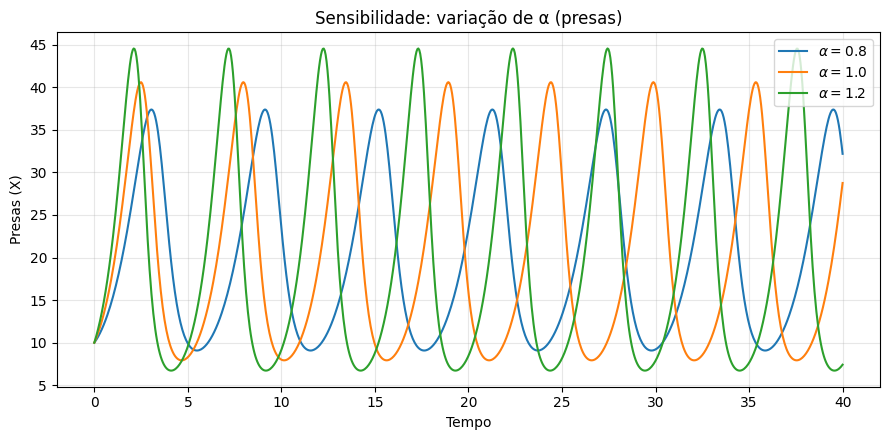

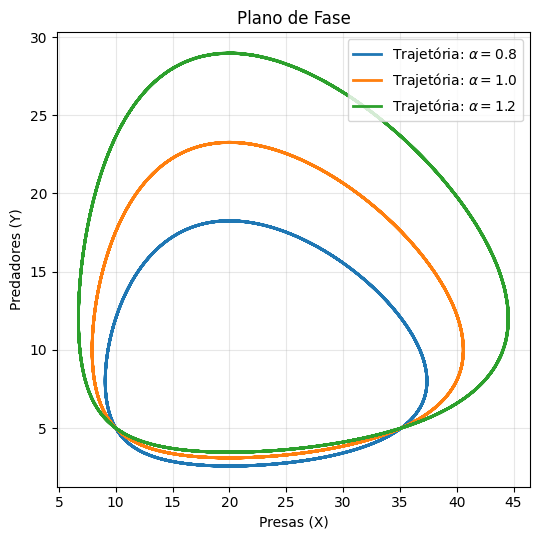

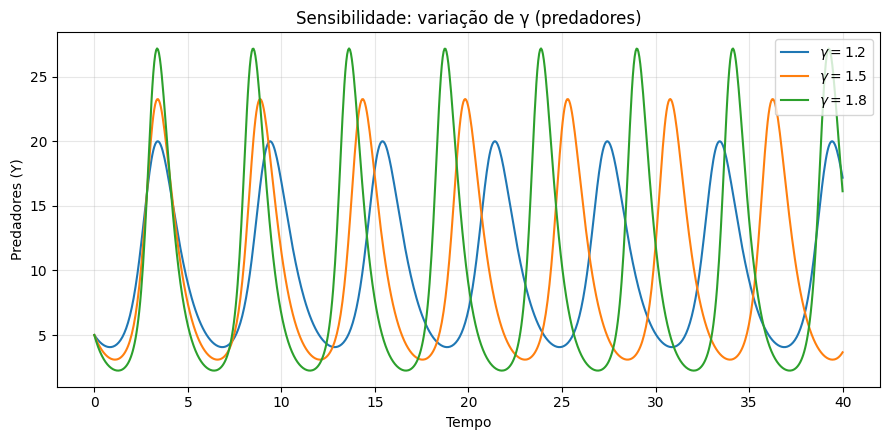

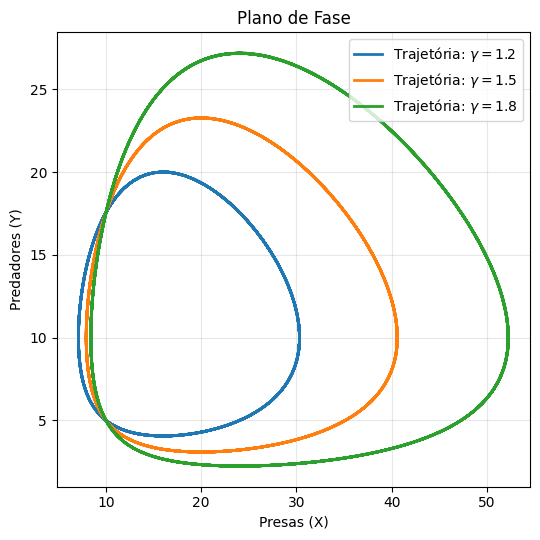

In [3]:
def sweep_params(base: LVParams, alphas = [0.8, 1.0, 1.2], gammas = [1.2, 1.5, 1.8], z0=(10.0, 5.0), t_span=(0, 40), n_points=800):
    # Variação de alpha (presas)
    plt.figure(figsize=(9, 4.5))
    for a in alphas:
        p = LVParams(alpha=a, beta=base.beta, gamma=base.gamma, delta=base.delta)
        t, X, Y = simulate_lv(p, z0=z0, t_span=t_span, n_points=n_points)
        plt.plot(t, X, label=fr'$\alpha={a:.1f}$')
    plt.xlabel('Tempo'); plt.ylabel('Presas (X)')
    plt.title('Sensibilidade: variação de α (presas)')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig('lv_sens_alpha.png', dpi=160); plt.show()
    
    # Plano de fase
    plt.figure(figsize=(5.5, 5.5))
    for a in alphas:
        p = LVParams(alpha=a, beta=base.beta, gamma=base.gamma, delta=base.delta)
        t, X, Y = simulate_lv(p, z0=z0, t_span=t_span, n_points=n_points)
        plt.plot(X, Y, linewidth=2.0, label=fr'Trajetória: $\alpha={a:.1f}$')
    plt.xlabel('Presas (X)')
    plt.ylabel('Predadores (Y)')
    plt.title('Plano de Fase')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('lv_phase_plane_var_alpha.png', dpi=160)
    plt.show()

    # Variação de gamma (predadores)
    plt.figure(figsize=(9, 4.5))
    for g in gammas:
        p = LVParams(alpha=base.alpha, beta=base.beta, gamma=g, delta=base.delta)
        t, X, Y = simulate_lv(p, z0=z0, t_span=t_span, n_points=n_points)
        plt.plot(t, Y, label=fr'$\gamma={g:.1f}$')
    plt.xlabel('Tempo'); plt.ylabel('Predadores (Y)')
    plt.title('Sensibilidade: variação de γ (predadores)')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig('lv_sens_gamma.png', dpi=160); plt.show()
    
    # Plano de fase
    plt.figure(figsize=(5.5, 5.5))
    for g in gammas:
        p = LVParams(alpha=base.alpha, beta=base.beta, gamma=g, delta=base.delta)
        t, X, Y = simulate_lv(p, z0=z0, t_span=t_span, n_points=n_points)
        plt.plot(X, Y, linewidth=2.0, label=fr'Trajetória: $\gamma={g:.1f}$')
    plt.xlabel('Presas (X)')
    plt.ylabel('Predadores (Y)')
    plt.title('Plano de Fase')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('lv_phase_plane_var_gamma.png', dpi=160)
    plt.show()
        

base = LVParams(alpha=1.0, beta=0.1, gamma=1.5, delta=0.075)
alphas = [0.8, 1.0, 1.2]
gammas = [1.2, 1.5, 1.8]
sweep_params(base,alphas,gammas)

### Validação rápida dos equilíbrios

A saída mostrará derivadas próximas de zero nos equilíbrios, corroborando a formulação analítica.

#### 4ª simulação: Comportamento do modelo na condição inicial do ponto de equilíbrio $[X,Y]=[0.0,0.0]$

Aqui a solução é trivial, o sistema já se inicia com ambas as populações extintas
**Condições iniciais**
> * $\alpha$ - Taxa de crescimento das presas sem predadores: **1.0**
> * $\beta$ - Taxa de predação, acoplamento X–Y: **0.1**
> * $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas: **1.5**  
> * $\delta$ - Eficiência de conversão de presas em predadores ou taxa de reprodução dos predadores: **0.075** 
> * $X$ - Tamanho da população de **Presas** no tempo $ t=0 $ : **0**
> * $Y$ - Tamanho da população de **Predadores** no tempo $ t=0 $ : **0**

#### 3ª simulação: Análise de sensibilidade do modelo à variação do parâmetro $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas
**Condições iniciais**
> * $\alpha$ - Taxa de crescimento das presas sem predadores: **1.0**
> * $\beta$ - Taxa de predação, acoplamento X–Y: **0.1**
> * $\gamma$ - Taxa de mortalidade natural dos predadores, sem presas: **1.5**  
> * $\delta$ - Eficiência de conversão de presas em predadores ou taxa de reprodução dos predadores: **0.075** 
> * $X$ - Tamanho da população de **Presas** no tempo $ t=0 $ : **20**
> * $Y$ - Tamanho da população de **Predadores** no tempo $ t=0 $ : **10**
 

E0 = (0.0, 0.0) -> (dX/dt, dY/dt) = (0.000000, 0.000000)


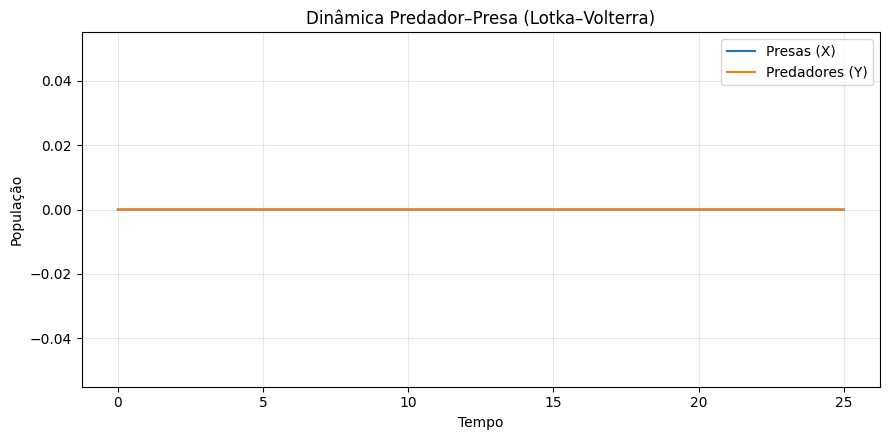

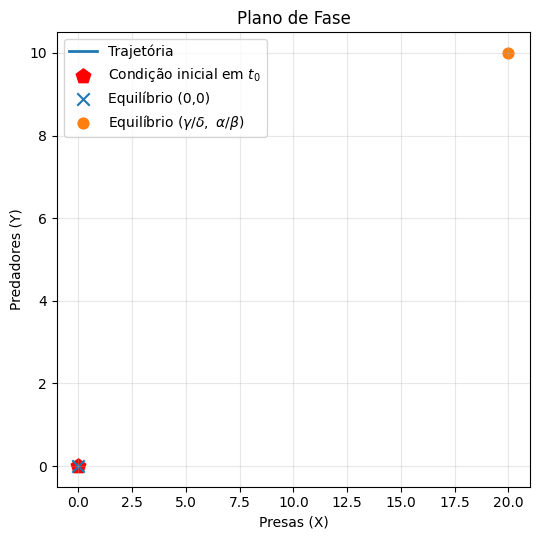

E1 = (20.0, 10.0) -> (dX/dt, dY/dt) = (0.000000, 0.000000)


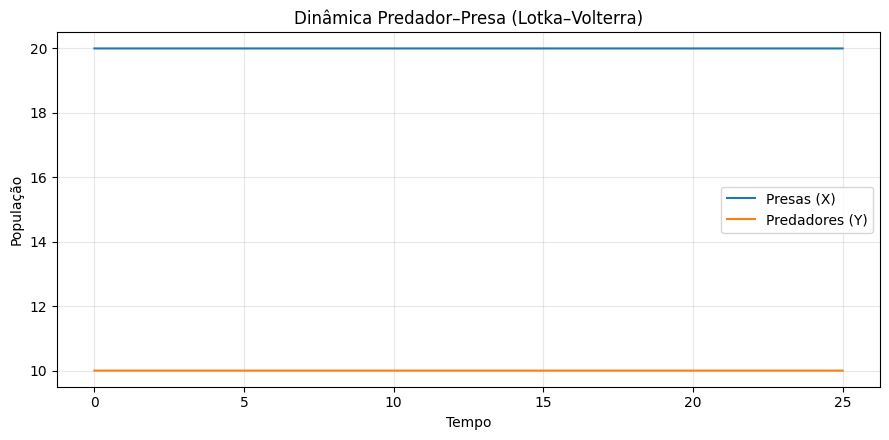

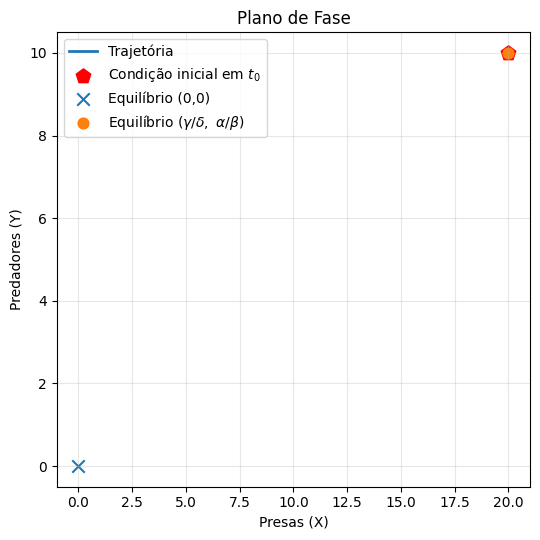

In [11]:
params = LVParams()
e0, e1 = equilibrium_points(params)
params = LVParams(alpha=1.0, beta=0.1, gamma=1.5, delta=0.075)

# Derivadas em cada equilíbrio (devem ser ~0):
for name, pt in [('E0', e0), ('E1', e1)]:
    dx, dy = lv_ode(0.0, np.array(pt, dtype=float), params)
    print(f"{name} = {pt} -> (dX/dt, dY/dt) = ({dx:.6f}, {dy:.6f})")
    
    t, X, Y = simulate_lv(params, z0=pt, t_span=(0, 25), n_points=1200)
    
    filename = f'lv_time_series_eq_{pt[0]:.0f}_{pt[1]:.0f}.png'
    plot_time_series(t, X, Y, params, pt,filename=filename)
    filename = f'lv_phase_plane_eq_{pt[0]:.0f}_{pt[1]:.0f}.png'
    plot_phase_plane(X, Y, params, pt,filename=filename)

## Natureza Conservativa do Modelo Lotka–Volterra

Uma das propriedades mais elegantes — e, ao mesmo tempo, limitantes — do modelo clássico de Lotka–Volterra é o seu caráter **não dissipativo**.
Isso significa que o sistema **não perde nem ganha “energia” dinâmica** ao longo do tempo. As populações não tendem naturalmente nem à extinção nem à estabilidade absoluta: elas oscilam **indefinidamente** em torno de um ponto de equilíbrio.

Matematicamente, esse comportamento surge porque o sistema admite uma **função integral de movimento** (ou primeiro integral):

$$H(X,Y)=\delta X− \gamma lnX+ \beta Y− \alpha lnY=C$$

Onde $C$ é uma constante determinada pelas condições iniciais.
Cada valor de $C$ define uma **curva fechada** no plano de fase $(X,Y)$, representando um “nível de energia” do sistema. Assim, uma vez iniciada a dinâmica, a trajetória **permanece confinada** nessa curva para sempre.

Em termos práticos:

* As populações de presas e predadores oscilam com **amplitude e período fixos**,
* Não há tendência de convergência para o ponto de equilíbrio,
* Não há divergência ilimitada — o sistema é **ciclicamente estável**.

O equilíbrio coexistente, dado por:

$$(X^∗,Y^∗)=\left(\frac{\gamma}{\delta},\frac{\alpha}{\beta}\right)$$

é um **centro neutro**: pequenas perturbações alteram apenas o valor de $C$, deslocando a órbita,** mas não crescendo nem decaindo** com o tempo.

### Interpretação física

Em ecossistemas reais, raramente observamos oscilações perfeitamente periódicas e eternas.
O fato de o modelo Lotka–Volterra não possuir dissipação reflete sua idealização matemática — ele ignora:

* **Capacidade de suporte** do ambiente (limite de recursos),
* **Mortalidades adicionais** por competição, doenças ou escassez,
* **Saturação** na taxa de predação (predadores não podem comer infinitamente rápido).

Esses fatores, quando incluídos em modelos mais avançados (como Rosenzweig–MacArthur ou Holling II), introduzem **termos dissipativos** que fazem o sistema **convergir** para um equilíbrio estável ou um ciclo limite.

No entanto, o modelo clássico permanece fundamental por representar o **caso limite ideal** de um sistema **puramente conservativo**, uma analogia biológica ao **oscilador harmônico** na física.

Essa característica não dissipativa explica por que, em suas simulações anteriores, as trajetórias não convergem — elas apenas **oscilam perpetuamente** em torno do equilíbrio.
É um comportamento matematicamente coerente e fisicamente interpretável: a ausência de atrito ecológico no modelo implica um ciclo eterno de predação e crescimento.

## Resultados e Interpretação das Simulações

Nesta seção, analisamos o comportamento dinâmico das populações simuladas a partir do modelo de Lotka–Volterra implementado anteriormente.
Os resultados são apresentados em dois formatos complementares:

1. Séries temporais, que mostram a evolução de presas e predadores ao longo do tempo;
2. Plano de fase, que revela a relação entre ambas as populações em um espaço bidimensional $(X,Y)$.

### Séries temporais — Dinâmica oscilatória

As figuras a seguir ilustram o comportamento típico do sistema para os parâmetros:

$$α=1.0,β=0.1,γ=1.5,δ=0.075$$

e condições iniciais $(X_0,Y_0)=(10,5)$.

![Séries temporais – Dinâmica predador-presa](lv_time_series_1.png)

A curva azul representa a população de **presas $X(t)$**, e a curva laranja, a de **predadores $Y(t)$**.
Observa-se um **comportamento periódico**: quando as presas crescem em abundância, os predadores encontram alimento suficiente para se multiplicar; à medida que a população de predadores aumenta, a de presas é reduzida, provocando posteriormente a queda dos próprios predadores.

Esse ciclo natural de crescimento e declínio se repete indefinidamente, mantendo o sistema em **oscilação contínua** — reflexo direto de sua **natureza conservativa**, discutida na seção anterior.

O período das oscilações depende principalmente dos parâmetros $\alpha$ e $\gamma$:

* Maiores taxas de crescimento $(\alpha)$ tornam o ciclo mais rápido
* Maiores taxas de mortalidade dos predadores $(\gamma)$ o tornam mais lento.


### Plano de fase — Retrato do equilíbrio dinâmico

![Plano de fase – Órbita em torno do equilíbrio](lv_phase_plane_1.png)

No **plano de fase**, cada ponto representa o estado do sistema em um instante — isto é, as populações simultâneas de presas $X$ e predadores $𝑌$.
A trajetória forma uma **curva fechada**, indicando que o sistema oscila em torno do ponto de equilíbrio de coexistência:

$$(X^∗,Y^∗)=(\frac{\delta}{\gamma},\frac{\beta}{\alpha})=(20,10).$$

Note que:

* O equilíbrio está no **centro geométrico** da trajetória;
* A forma da órbita (ovalada ou circular) depende da razão entre as taxas de crescimento e mortalidade;
* Trajetórias iniciadas em diferentes condições iniciais geram órbitas concêntricas, todas fechadas — indicando que o sistema conserva uma grandeza invariante (a "energia ecológica" $H(X,Y)$).

### Sensibilidade de parâmetros

Os experimentos de sensibilidade revelam que pequenas mudanças em $\alpha$ e $\gamma$ alteram significativamente o padrão de oscilação:

* Aumentar $\alpha$ (crescimento das presas) resulta na ampliação do número médio de presas e sustenta maior número de predadores;
* Aumentar $\gamma$ (mortalidade dos predadores) resulta na reduzção do número médio de predadores e diminui a amplitude global das oscilações.

Esses resultados mostram que, embora o modelo seja simples, ele **reage de forma coerente** a ajustes em seus parâmetros, tornando-se uma excelente ferramenta conceitual para explorar estabilidade e controle de populações.

![Plano de fase – Órbita em torno do equilíbrio](lv_phase_plane_var_alpha.png) ![Plano de fase – Órbita em torno do equilíbrio](lv_phase_plane_var_gamma.png)

### Discussão

O comportamento obtido é **periódico e conservativo**, coerente com o equilíbrio neutro demonstrado analiticamente.
Essa característica torna o modelo uma ótima base para estudos introdutórios em:

* **Dinâmica não linear**,
* **Controle ecológico**,
* **Engenharia de sistemas complexos**,

onde pequenas alterações nos termos diferenciais podem gerar estabilidade, caos ou colapso.

Em termos de engenharia, o modelo Lotka–Volterra pode ser interpretado como um **oscilador acoplado**, em que as populações desempenham papéis análogos a **energia armazenada e transferida**.
Essa analogia inspira o uso do mesmo formalismo em domínios como **circuitos elétricos, controle de feedback, competição de mercados** e até **interação de algoritmos de IA competitivos**.


### Próximos passos sugeridos

Futuramente podem ser exploradas variações de modelos mais realistas e dissipativas, tais como:

* **Lotka–Volterra com crescimento logístico** (Rosenzweig–MacArthur);
* **Resposta funcional de Holling tipo II** (predação saturante);
* **Modelos estocásticos** e com **atrasos temporais**;
* **Formulação controlada**, onde um agente regula a dinâmica para manter as populações próximas do equilíbrio desejado

Em engenharia, o modelo pode ser reinterpretado de várias formas:

| **Domínio**                         | **Interpretação**                                                                                                 |
| ----------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **Mecânica**                        | Um oscilador acoplado sem amortecimento (energia cinética e potencial alternando).                                |
| **Elétrica**                        | Um circuito LC ideal (indutor–capacitor) sem resistência, onde a energia oscila entre campo elétrico e magnético. |
| **Controle**                        | Um sistema de realimentação positiva e negativa em equilíbrio marginal.                                           |
| **Economia/Competição tecnológica** | Dois agentes competindo por recursos, com ciclos de dominância alternada.                                         |


Essa equivalência estrutural mostra como as equações diferenciais não lineares descrevem **padrões de comportamento universais**, independentemente do domínio físico.

## Conclusão

O modelo Lotka–Volterra, embora simples, sintetiza três lições fundamentais aplicáveis à engenharia moderna:

1. Simplicidade estrutural não implica trivialidade dinâmica — sistemas de duas equações podem gerar comportamentos ricos e não lineares.
2. Conservação e dissipação são chaves para entender estabilidade, tanto em ecossistemas quanto em máquinas e circuitos.
3. Modelagem matemática, otimização e controle formam um ciclo contínuo: compreender → simular → ajustar → estabilizar.

Esses conceitos, originalmente biológicos, são hoje pilares em campos como **controle adaptativo, otimização robusta, modelagem de sistemas complexos e engenharia de energia** — especialmente na modelagem e gerenciamento de **sistemas de baterias, fluxos térmicos, e estratégias de controle não linear**.


## Referências

- LOTKA, A. J. (1925). Elements of Physical Biology. Williams & Wilkins. Disponível em: [https://www.ifisica.uaslp.mx/~ugalde/Cursos/DinamicosPCA/VolterraPaper1926.pdf)](https://www.ifisica.uaslp.mx/~ugalde/Cursos/DinamicosPCA/VolterraPaper1926.pdf). Acesso em: 30 outubro 2025. 

- VOLTERA, V. (1926). “Variazioni e fluttuazioni del numero d’individui in specie animali conviventi”. Memorie della Reale Accademia dei Lincei, Serie VI, Vol. 2, 31-113. Disponível em: [https://liberliber.it/autori/autori-v/vito-volterra/variazioni-e-fluttuazioni-del-numero-dindividui-in-specie-animali-conviventi](https://liberliber.it/autori/autori-v/vito-volterra/variazioni-e-fluttuazioni-del-numero-dindividui-in-specie-animali-conviventi). Acesso em 30 outrubro 2025.

- STROGATZ, S. H. (2018). Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering. CRC Press. Capítulo 6: Predator–Prey Equations.

- MURRAY, J. D. (2002). Mathematical Biology I: An Introduction. Springer-Verlag, 3ª ed.

- Khalil, H. K. (2002). Nonlinear Systems. Prentice Hall.

- SciPy Documentation – solve_ivp. Disponível em: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). Acesso em: 30 outubro 2025. 

- ModelDB (CellML): Modelo de Lotka–Volterra em formato interoperável CellML. Disponível em: [https://models.cellml.org/exposure/8e1f599901dab590a61564292b4818f5](https://models.cellml.org/exposure/8e1f599901dab590a61564292b4818f5). Acesso em: 30 outubro 2025. 

- Artigo de revisão histórico (PMC): Alfred J. Lotka and the Origins of Theoretical Population Ecology. Disponível em: [https://pmc.ncbi.nlm.nih.gov/articles/PMC4534218/](https://pmc.ncbi.nlm.nih.gov/articles/PMC4534218/). Acesso em: 30 outubro 2025. 